In [1]:
import boto3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
from pyathena import connect
import io
from bs4 import BeautifulSoup
from scipy.stats import zscore
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from dotenv import load_dotenv
import re
import os
import sagemaker
import s3fs
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [4]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

# Data Extraction

## Retrieving European Space Agency (ESA) Data

In [ ]:
load_dotenv()

# API Endpoint
esa_api_url = "https://discosweb.esoc.esa.int/api/objects"

# Your Personal Access Token
token = os.getenv('esa_token')

# Set up authentication headers
headers = {
    "Authorization": f"Bearer {token}",
    "DiscosWeb-Api-Version": "2",
    "Accept": "application/vnd.api+json"
}

# Query Parameters (Retrieving all object attributes)
params = {
    "page[size]": 100,  # Max allowed per page
}

# List to store all object records
all_data = []
page = 1  # Start with page 1

with tqdm(desc="Fetching Data", unit=" records", smoothing=0.1) as pbar:
    while True:
        params["page[number]"] = page  # Set current page number
        response = requests.get(esa_api_url, headers=headers, params=params)

        if response.status_code == 200:
            data = response.json()
            
            if "data" in data and data["data"]:
                all_data.extend(data["data"])  # Store raw data
                pbar.update(len(data["data"]))  # Update progress bar
            else:
                break  # Stop if no more data
            
            page += 1  # Move to next page
        else:
            print(f"❌ Error: {response.status_code}, {response.text}")
            break

# Extract all object attributes
esa_df = pd.DataFrame([obj["attributes"] for obj in all_data])

# Save as Parquet for efficiency
# esa_df.to_parquet("data/raw data/full_esa_data.parquet", index=False)

print(f"✅ Retrieved {len(satcat_df)} records and saved as Parquet!")

## Scrape Lost Object Data from CelesTrek

In [1]:
# Base URL for lost satellites
base_url = "https://celestrak.org/satcat/lost.php"

# Initialize empty list to store data
all_rows = []

# Fetch the first page to determine pagination
response = requests.get(base_url)
if response.status_code != 200:
    print(f"Failed to retrieve data: {response.status_code}")
else:
    soup = BeautifulSoup(response.text, "html.parser")

    # Find the total number of pages (if pagination exists)
    pagination = soup.find("div", class_="pagination")
    if pagination:
        pages = [a.text for a in pagination.find_all("a") if a.text.isdigit()]
        total_pages = max(map(int, pages)) if pages else 1
    else:
        total_pages = 1  # If no pagination, assume one page

    print(f"Total pages found: {total_pages}")

    # Loop through all pages
    for page in range(1, total_pages + 1):
        print(f"Scraping page {page}...")
        page_url = f"{base_url}?page={page}" if total_pages > 1 else base_url
        response = requests.get(page_url)
        
        if response.status_code != 200:
            print(f"Failed to retrieve page {page}: {response.status_code}")
            continue
        
        soup = BeautifulSoup(response.text, "html.parser")
        table = soup.find("table")
        
        if table:
            # Extract headers from first page only
            if page == 1:
                headers = [header.text.strip() for header in table.find_all("th")]

            # Extract data rows
            for row in table.find_all("tr")[1:]:  # Skip header row
                cols = [col.text.strip() for col in row.find_all("td")]
                if cols:
                    all_rows.append(cols)

# Convert to DataFrame
lost_object_satcat_df = pd.DataFrame(all_rows, columns=headers)

#Ingest to folder
lost_object_satcat_df.to_csv("data/raw data/lost_objects.csv", index = False)


NameError: name 'requests' is not defined

## Retrieve Low Earth Object data from Space Track

In [ ]:
# Space-Track login credentials
USERNAME = os.getenv('user')
PASSWORD = os.getenv('pass')

# Space-Track API URL for querying LEO satellites (sample query from website)
url = "https://www.space-track.org/basicspacedata/query/class/satcat/PERIOD/<128/DECAY/null-val/CURRENT/Y/"

# Create a session for authentication
session = requests.Session()

# Authenticate with space-track.org
login_url = "https://www.space-track.org/ajaxauth/login"
login_data = {"identity": USERNAME, "password": PASSWORD}
session.post(login_url, data=login_data)

# Fetch JSON data
response = session.get(url)

# Ensure request was successful
if response.status_code == 200:
    json_data = response.json()  # Convert response to JSON format

    # Convert JSON to Pandas DataFrame
    leo_satcat_df = pd.DataFrame(json_data)

    #leo_satcat_df.to_csv("data/raw data/leo_objects.csv", index = False)

else:
    print("Failed to retrieve data. Check credentials or API access.")
    print(response.text)


# Ingest into s3 bucket

In [5]:
!aws s3 cp "data/raw data/full_esa_data.parquet" "s3://{bucket}/data/raw_data/full_esa_folder/"
!aws s3 cp "data/raw data/full_satcat.csv" "s3://{bucket}/data/raw_data/satcat_folder/"
!aws s3 cp "data/raw data/leo_objects.csv" "s3://{bucket}/data/raw_data/leo_objects_folder/"
!aws s3 cp "data/raw data/lost_objects.csv" "s3://{bucket}/data/raw_data/lost_objects_folder/"
!aws s3 cp "data/raw data/simplified_collision_data.csv" "s3://{bucket}/data/raw_data/simplified_collision_folder/"

upload: data/raw data/full_esa_data.parquet to s3://sagemaker-us-east-1-662949783070/data/raw_data/full_esa_folder/full_esa_data.parquet
upload: data/raw data/full_satcat.csv to s3://sagemaker-us-east-1-662949783070/data/raw_data/satcat_folder/full_satcat.csv
upload: data/raw data/leo_objects.csv to s3://sagemaker-us-east-1-662949783070/data/raw_data/leo_objects_folder/leo_objects.csv
upload: data/raw data/lost_objects.csv to s3://sagemaker-us-east-1-662949783070/data/raw_data/lost_objects_folder/lost_objects.csv
upload: data/raw data/simplified_collision_data.csv to s3://sagemaker-us-east-1-662949783070/data/raw_data/simplified_collision_folder/simplified_collision_data.csv


# EDA

## Full ESA

In [ ]:
df = pd.read_parquet('Data to use/full_esa_data.parquet')

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
vimpelId,14933.0,95640.434943,45331.952486,9600.000000,69211.000000,79106.000000,141218.000000,1.346400e+06
satno,63052.0,31543.718455,18220.717310,1.000000,15766.750000,31534.500000,47302.250000,6.315500e+04
mass,34050.0,1807.384763,7269.503234,0.001500,130.820000,500.000000,1600.000000,4.500000e+05
width,18430.0,2.231862,2.070336,0.000000,0.400000,2.200000,3.700000,7.280000e+01
height,32680.0,3.278075,5.173099,0.001000,0.300000,1.200000,5.500000,6.000000e+01
depth,18403.0,1.888098,2.977385,0.012000,0.500000,1.500000,2.700000,1.085000e+02
diameter,14809.0,2.309130,1.438350,0.001000,1.400000,2.400000,3.000000,4.114000e+01
span,32380.0,9.730365,152.026790,0.020000,1.500000,6.500000,8.990000,1.920000e+04
xSectMax,32980.0,28.481166,101.742724,0.000130,1.375159,16.219661,25.626695,8.319848e+03
xSectMin,32980.0,4.637487,37.008288,0.000000,0.231100,0.810000,4.523893,1.521000e+03


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81941 entries, 0 to 81940
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cosparId                    67666 non-null  object 
 1   vimpelId                    14933 non-null  float64
 2   satno                       63052 non-null  float64
 3   name                        67390 non-null  object 
 4   objectClass                 81941 non-null  object 
 5   mass                        34050 non-null  float64
 6   shape                       33235 non-null  object 
 7   width                       18430 non-null  float64
 8   height                      32680 non-null  float64
 9   depth                       18403 non-null  float64
 10  diameter                    14809 non-null  float64
 11  span                        32380 non-null  float64
 12  xSectMax                    32980 non-null  float64
 13  xSectMin                    329

**Can immediately see that some features will need data types changed such as satno or predDecayDate**

**Check outliers**

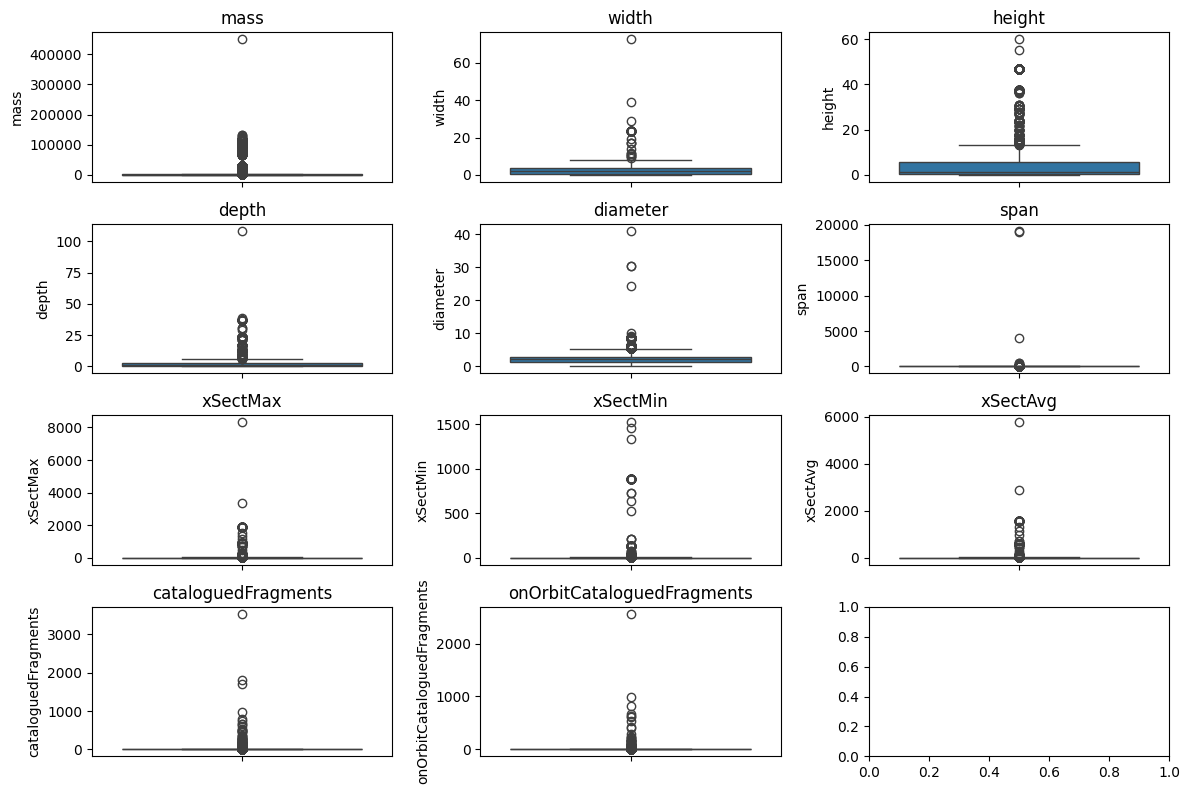

In [ ]:
# Create a list of numeric columns to plot
numeric_cols = ['mass', 'width', 'height', 'depth', 'diameter', 'span', 'xSectMax', 'xSectMin','xSectAvg', 
                'cataloguedFragments', 'onOrbitCataloguedFragments']

# Set up the matplotlib grid
fig, axes = plt.subplots(4, 3, figsize=(12, 8))  # 2x2 grid

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each numeric column and plot
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col}')

plt.tight_layout()
plt.show()


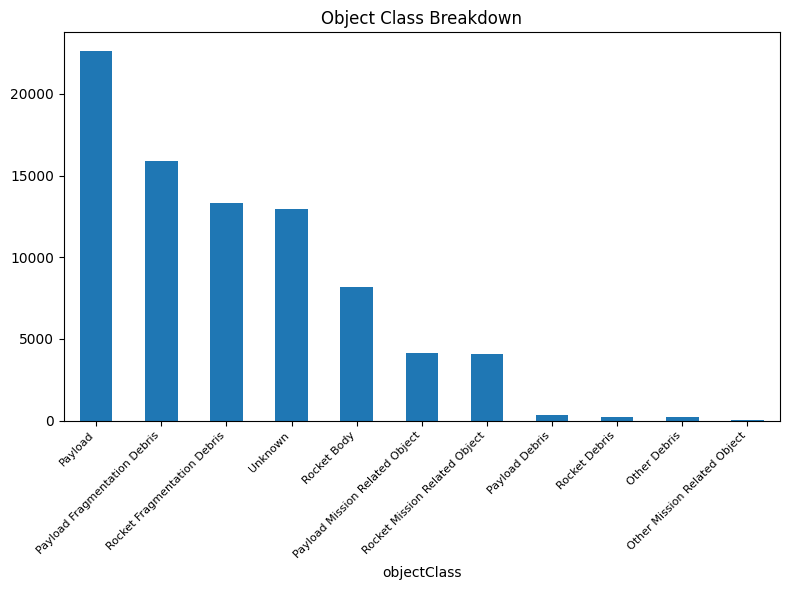

In [61]:
import matplotlib.pyplot as plt
import textwrap

plt.figure(figsize = (8, 6))

ax = df['objectClass'].value_counts().plot(kind='bar', title="Object Class Breakdown")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()


<Axes: xlabel='firstEpoch'>

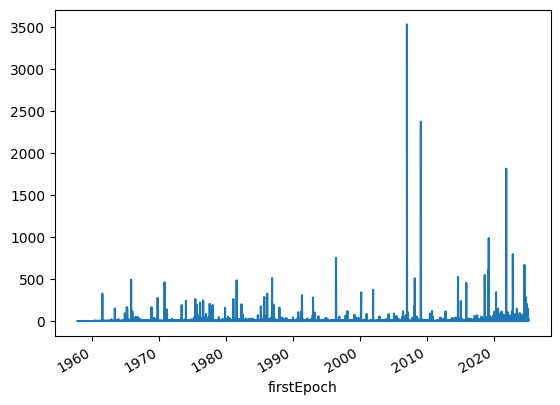

In [40]:
df['firstEpoch'] = pd.to_datetime(df['firstEpoch'])

df['firstEpoch'].value_counts().sort_index().plot(x = 'firstEpoch', kind = 'line')

**Missing Values**

In [23]:
df.isna().sum()

cosparId                      14275
vimpelId                      67008
satno                         18889
name                          14551
objectClass                       0
mass                          47891
shape                         48706
width                         63511
height                        49261
depth                         63538
diameter                      67132
span                          49561
xSectMax                      48961
xSectMin                      48961
xSectAvg                      49021
firstEpoch                     4104
mission                       59226
predDecayDate                 42464
active                        70418
cataloguedFragments               0
onOrbitCataloguedFragments        0
dtype: int64

In [ ]:
!aws s3 cp 's3://sagemaker-us-east-1-266917422334/data/lost_objects.csv' ./data-folder/

In [ ]:
df = pd.read_csv("data-folder/lost_objects.csv")

In [ ]:
df.shape

(2582, 8)

In [ ]:
df.head()

,International Designator,NORAD Catalog Number,Satellite Name,Source,Launch Date,Launch Site,Object Type,Last Data
0,1960-009D,52.0,ECHO 1 DEB [MYLAR OBJ],US,1960-08-12,AFETR,DEB,1991-03-25T14:23:57.069312
1,1963-039C,692.0,VELA 1,US,1963-10-17,AFETR,PAY-,2024-11-06T17:09:09.800928
2,1964-040A,836.0,OPS 3662 (VELA 3),US,1964-07-17,AFETR,PAY-,2024-10-18T19:49:13.468512
3,1965-058A,1458.0,OPS 6577 (VELA 5),US,1965-07-20,AFETR,PAY-,2025-01-24T09:01:13.708704
4,1965-058B,1459.0,OPS 6564 (VELA 6),US,1965-07-20,AFETR,PAY-,2024-12-24T02:18:46.645344


In [ ]:
df['Launch Site'].value_counts()

Launch Site
TYMSC    682
TAISC    614
PLMSC    469
AFETR    325
AFWTR    201
XICLF    112
FRGUI    107
WLPIS     26
SRILR     25
TANSC      4
JSC        4
SEAL       3
KSCUT      2
KWAJ       2
RLLB       2
DLS        1
ERAS       1
WSC        1
Name: count, dtype: int64

<Axes: xlabel='Source'>

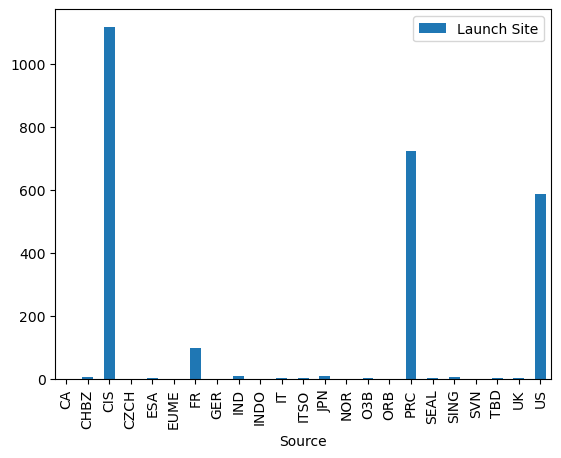

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

df[['Launch Site', 'Source']].groupby('Source').count().plot(kind = 'bar')

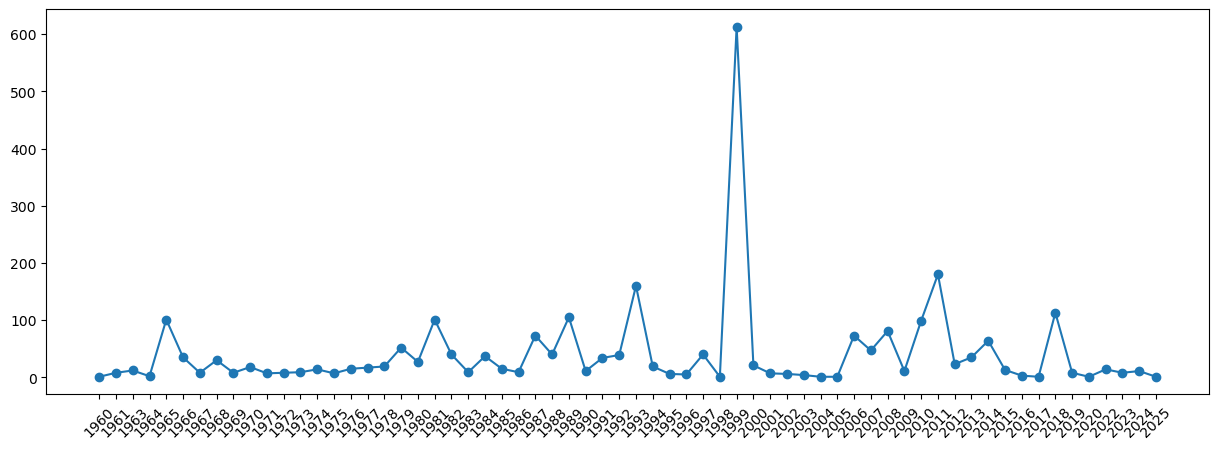

In [ ]:
df['Launch Date'] = pd.to_datetime(df['Launch Date'])
launch_counts = df.groupby(df['Launch Date'].dt.to_period("Y"))['International Designator'].count()

launch_counts.index = launch_counts.index.astype(str)

plt.figure(figsize = (15,5))

plt.plot(launch_counts.index, launch_counts.values, marker = 'o', linestyle = '-')

plt.xticks(rotation = 45)

plt.show()

In [ ]:
df['Object Type'].value_counts()

Object Type
DEB     2492
PAY-      37
R/B       25
PAY+      25
UNK        2
Name: count, dtype: int64

In [ ]:
# Combining all into one DataFrame
combined_df = pd.concat([
    esa_df_small,
    full_satcat_df_small,
    lost_objects_df_small,
    loe_objects_df_small
], ignore_index=True)

# Dropping the rows with missing object_type
combined_df = combined_df.dropna(subset=['object_type'])

print("Combined dataset shape:", combined_df.shape)
combined_df.head()

Combined dataset shape: (152122, 4)


,object_name,object_type,timestamp,source
0,Calsphere 1,PAYLOAD,1964-10-06,ESA
1,Calsphere 2,PAYLOAD,1964-10-06,ESA
2,LCS 1,PAYLOAD,1965-05-06,ESA
3,Tempsat 1,PAYLOAD,1965-08-13,ESA
4,Calsphere 4,PAYLOAD,1965-08-13,ESA


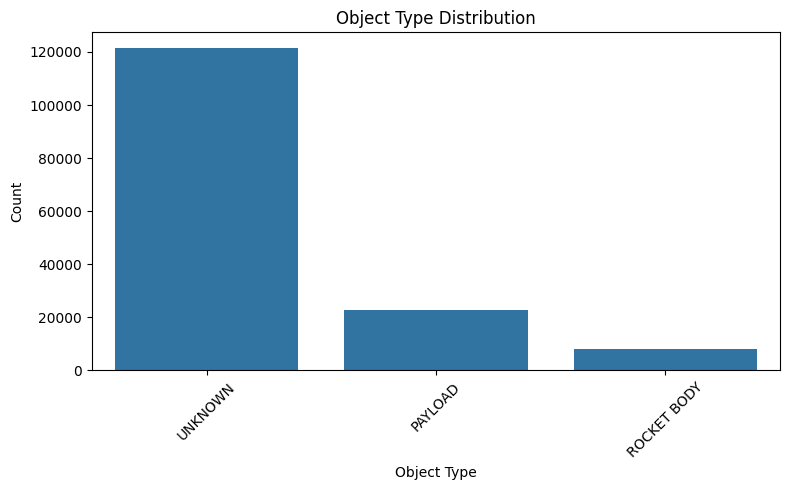

In [ ]:
# Ploting object type distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data=combined_df, x='object_type', order=combined_df['object_type'].value_counts().index)
plt.title("Object Type Distribution")
plt.xlabel("Object Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

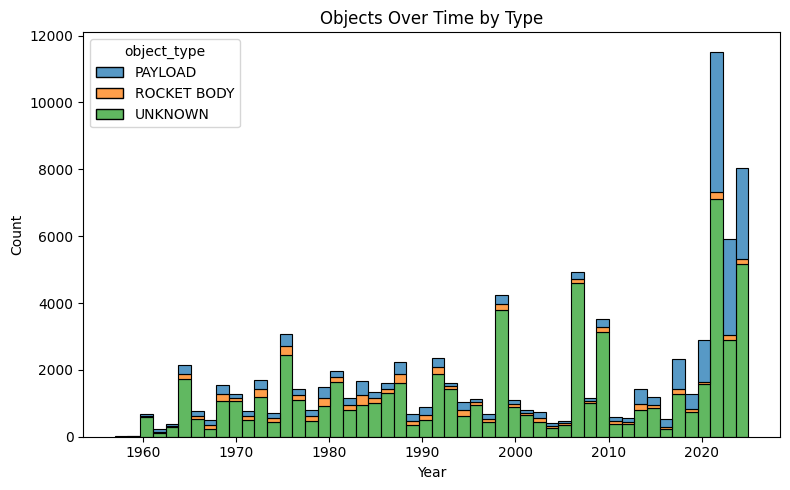

In [ ]:
# Ploting object frequency by year
combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'], errors='coerce')

# Drop rows with invalid dates (NaT)
combined_df = combined_df.dropna(subset=['timestamp'])

combined_df['year'] = combined_df['timestamp'].dt.year
plt.figure(figsize=(8, 5))
sns.histplot(data=combined_df, x='year', hue='object_type', multiple='stack', bins=50)
plt.title("Objects Over Time by Type")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Athena Tables

## Create variable paths and store them

In [ ]:
esa_path = "s3://{}/data/processed_data/esa_folder/".format(bucket)
leo_path = "s3://{}/data/processed_data/leo_objects_folder/".format(bucket)
lost_path = "s3://{}/data/processed_data/lost_object_folder/".format(bucket)
satcat_path = "s3://{}/data/processed_data/satcat_folder/".format(bucket)
collision_path = "s3://{}/data/processed_data/collision_data_folder/".format(bucket)

In [ ]:
%store esa_path
%store leo_path
%store lost_path
%store satcat_path
%store collision_path

## Create tables names

In [ ]:
table_name1 = "esa"
table_name2 = 'leo'
table_name3 = 'lost_objects'
table_name4 = 'satcat'
table_name5 = 'collision'

## Retrieve dataframes from directories

In [ ]:
# Create filesystem object

fs = s3fs.S3FileSystem()

# Retrieve all files paths

parquet_paths = fs.find(f"{bucket}/data/processed_data/")

# Loop through and add to a list

dataframes = [pd.read_parquet(f"s3://{path}") for path in parquet_paths]

# Save each df to own variable

collision_df = dataframes[0]
esa_df = dataframes[2]
leo_df = dataframes[3]
lost_df = dataframes[4]
satcat_df = dataframes[5]

## Create staging directory path and initiate connection

In [ ]:
s3_staging_dir = "s3://{}/athena/staging".format(bucket)

In [ ]:
%store s3_staging_dir

In [ ]:
conn = connect(region_name = region, s3_staging_dir = s3_staging_dir)

## Check current databases

In [ ]:
pd.read_sql("SHOW DATABASES", conn)

In [ ]:
# Connect to project database

project_conn = connect(region_name = region, s3_staging_dir = s3_staging_dir, schema_name = 'space_project')

## Helper functions to generate table creation statements

In [ ]:
def map_dtype_to_athena(dtype):
    dtype = str(dtype)
    if 'int' in dtype:
        return 'int'
    elif 'float' in dtype:
        return 'double'
    elif 'bool' in dtype:
        return 'boolean'
    elif 'datetime' in dtype:
        return 'timestamp'
    else:
        return 'string'  # default to string for object, category, etc.

In [ ]:
def generate_athena_columns(df):
    cols = []
    for col in df.columns:
        athena_type = map_dtype_to_athena(df[col].dtype)
        cols.append(f"    {col} {athena_type}")
    return ",\n".join(cols)

In [ ]:
def create_athena_table_statement(table_name, s3_path, df, database_name='space_project'):
    columns = generate_athena_columns(df)
    statement = f"""CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name} (
{columns}
)
STORED AS PARQUET
LOCATION '{s3_path}'"""
    return statement

## Create table statement then test to make sure connection went through

In [ ]:
esa_statement = create_athena_table_statement(table_name1, esa_path, esa_df)

In [ ]:
pd.read_sql(esa_statement, project_conn)

pd.read_sql('SELECT * FROM esa LIMIT 5', project_conn)

## Create other tables

In [ ]:
collision_statement = create_athena_table_statement(table_name5, collision_path, collision_df)
leo_statement = create_athena_table_statement(table_name2, leo_path, leo_df)
lost_statement = create_athena_table_statement(table_name3, lost_path, lost_df)
satcat_statement = create_athena_table_statement(table_name4, satcat_path, satcat_df)

pd.read_sql(collision_statement, conn)
pd.read_sql(leo_statement, conn)
pd.read_sql(lost_statement, conn)
pd.read_sql(satcat_statement, conn)

## Check all tables were created

In [ ]:
# Check all tables are there

pd.read_sql("SHOW TABLES", project_conn)

# Clean/Transform

## ESA Data

In [84]:
esa_df = pd.read_parquet(f"s3://{bucket}/data/raw_data/full_esa_folder/full_esa_data.parquet")

In [85]:
# Columns with too many missing values or not useful for modeling

columns_to_drop = ['vimpelId', 'satno', 'predDecayDate', 'active', 'mission', 'shape', 'mass', 'width', 'height', 'depth', 'xSectMax', 'xSectMin']

In [86]:
# Drop columns and check missing values again

esa_df.drop(columns = columns_to_drop, inplace = True)

esa_df.isna().sum()

cosparId                      14275
name                          14551
objectClass                       0
diameter                      67132
span                          49561
xSectAvg                      49021
firstEpoch                     4104
cataloguedFragments               0
onOrbitCataloguedFragments        0
dtype: int64

In [87]:
# Change to Date time

esa_df['firstEpoch'] = pd.to_datetime(esa_df['firstEpoch'])

In [88]:
# Lot of rows are all NA or 0, but have positive values for first Epoch, so removing those

exclude_col = ['firstEpoch', 'objectClass']

# Drop rows where all values (except the exclude_col) are NA or 0
esa_df = esa_df[~((esa_df.drop(columns=exclude_col).isna()) | (esa_df.drop(columns=exclude_col) == 0)).all(axis=1)]

esa_df.isna().sum()

cosparId                        458
name                            734
objectClass                       0
diameter                      53315
span                          35744
xSectAvg                      35204
firstEpoch                     4073
cataloguedFragments               0
onOrbitCataloguedFragments        0
dtype: int64

In [89]:
# Name and object class are still necessary, so if both are null then remove, otherwise keep and deal with the other missing data as needed

esa_df_cleaned = esa_df[~esa_df[['cosparId', 'name']].isna().all(axis = 1)]

esa_df_cleaned.isna().sum()

cosparId                        458
name                            734
objectClass                       0
diameter                      53315
span                          35744
xSectAvg                      35204
firstEpoch                     4073
cataloguedFragments               0
onOrbitCataloguedFragments        0
dtype: int64

In [14]:
# Save this esa dataframe separately to graph object class for Goal # 1 before further processing for modeling

esa_df_cleaned.to_parquet("data/processed data/cleaned_esa_goal1.parquet", index = False)
esa_df_cleaned.to_parquet(f"s3://{bucket}/data/processed_data/esa_folder/cleaned_esa_goal1.parquet", index = False)

In [90]:
# Make a copy and collapse objectClass category into 4 values

esa_df_modeling = esa_df_cleaned.copy()

esa_df_modeling['objectClass'] = esa_df_modeling['objectClass'].apply(lambda x: 'Debris' if 'Debris' in x else x)
esa_df_modeling.loc[esa_df_modeling['objectClass'].str.contains('Mission'), 'objectClass'] = 'Debris'

In [92]:
esa_df_modeling.columns

Index(['cosparId', 'name', 'objectClass', 'diameter', 'span', 'xSectAvg',
       'firstEpoch', 'cataloguedFragments', 'onOrbitCataloguedFragments'],
      dtype='object')

In [91]:
# Standardize the numerical features and save

standard_cols = ['diameter', 'span', 'xSectAvg', 'cataloguedFragments', 'onOrbitCataloguedFragments']

esa_df_modeling[['diameter', 'span', 'xSectAvg']] = esa_df_modeling[['diameter', 'span', 'xSectAvg']].apply(lambda x: x.fillna(x.median()))

esa_df_modeling[standard_cols] = esa_df_modeling[standard_cols].apply(zscore)

In [95]:
# Rename columns for consistency

esa_df_modeling.rename(columns = {
    'cosparId': 'object_id',
    'name': 'object_name',
    'objectClass': 'object_type',
    'firstEpoch': 'launch_date'
},
                      inplace = True)

In [96]:
# Standardize column names
esa_df_modeling.columns = esa_df_modeling.columns.str.strip().str.lower().str.replace(" ", "_")

print("Updated Column Names:\n", esa_df_modeling.columns)

Updated Column Names:
 Index(['object_id', 'object_name', 'object_type', 'diameter', 'span',
       'xsectavg', 'launch_date', 'cataloguedfragments',
       'onorbitcataloguedfragments'],
      dtype='object')


In [97]:
esa_df_modeling.to_parquet("data/processed data/esa_df_modeling.parquet", index = False)
esa_df_modeling.to_parquet(f"s3://{bucket}/data/processed_data/esa_folder/esa_df_modeling.parquet", index = False)

## Satcat

In [23]:
satcat_df = pd.read_csv(f"s3://{bucket}/data/raw_data/satcat_folder/full_satcat.csv")

In [24]:
# Check for missing values

missing_values = satcat_df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 Unnamed: 0              0
OBJECT_NAME             0
OBJECT_ID               0
NORAD_CAT_ID            0
OBJECT_TYPE             0
OPS_STATUS_CODE     17248
OWNER                   0
LAUNCH_DATE             0
LAUNCH_SITE             0
DECAY_DATE          30136
PERIOD                908
INCLINATION           908
APOGEE                908
PERIGEE               908
RCS                 30142
DATA_STATUS_CODE    61902
ORBIT_CENTER            0
ORBIT_TYPE              0
dtype: int64


In [25]:
# Check unique values per column

unique_counts = satcat_df.nunique().sort_values()
print("Unique Values per Column:\n", unique_counts)

Unique Values per Column:
 DATA_STATUS_CODE        3
OBJECT_TYPE             4
ORBIT_TYPE              4
OPS_STATUS_CODE         7
ORBIT_CENTER           18
LAUNCH_SITE            36
OWNER                 125
PERIGEE              3719
LAUNCH_DATE          5644
APOGEE               6658
INCLINATION          6800
PERIOD               8261
RCS                 10800
DECAY_DATE          14562
OBJECT_NAME         22276
OBJECT_ID           63073
Unnamed: 0          63073
NORAD_CAT_ID        63073
dtype: int64


In [26]:
# Drop uneccessary columns

columns_to_drop = ['Unnamed: 0', 'DATA_STATUS_CODE', 'RCS', 'OPS_STATUS_CODE', 'DATA_STATUS_CODE']
satcat_df = satcat_df.drop(columns = columns_to_drop)

# Only concerned with objects in orbit around Earth, so remove all others

satcat_df = satcat_df[satcat_df['ORBIT_CENTER'] == 'EA']
satcat_df = satcat_df.drop(columns = 'ORBIT_CENTER')

In [27]:
# Change names of orbit type to be consistent with others

satcat_df['OBJECT_TYPE'] = satcat_df['OBJECT_TYPE'].replace({
    'DEB': 'DEBRIS',
    'PAY': 'PAYLOAD',
    'R/B': 'ROCKET BODY',
    'UNK': 'UNKNOWN'
})

satcat_df['NORAD_CAT_ID'] = satcat_df['NORAD_CAT_ID'].astype('str')

In [28]:
# Fill in some of the NA values for the distance and location metrics.  If orbit type is IMP or LAN that means they're no longer in orbit

satcat_df.loc[(satcat_df['ORBIT_TYPE'] == 'IMP') | (satcat_df['ORBIT_TYPE'] == 'LAN'), ['PERIOD', 'INCLINATION', 'APOGEE', 'PERIGEE']] = 0

# If still in orbit, impute the median (to adjust for outliers)

cols = ['PERIOD', 'INCLINATION', 'APOGEE', 'PERIGEE']
satcat_df[cols] = satcat_df[cols].fillna(satcat_df[satcat_df['ORBIT_TYPE'] == 'ORB'][cols].median())

In [29]:
# Create new columns called Has Decayed so Decay Dates can be kept

satcat_df['HAS_DECAYED'] = satcat_df['DECAY_DATE'].notna().astype(int)

In [30]:
# Standardize column names

satcat_df.columns = satcat_df.columns.str.strip().str.lower().str.replace(" ", "_")

print("Updated Column Names:\n", satcat_df.columns)

Updated Column Names:
 Index(['object_name', 'object_id', 'norad_cat_id', 'object_type', 'owner',
       'launch_date', 'launch_site', 'decay_date', 'period', 'inclination',
       'apogee', 'perigee', 'orbit_type', 'has_decayed'],
      dtype='object')


In [31]:
# Convert date columns 

date_columns = ["launch_date", 'decay_date']  
for col in date_columns:
    if col in satcat_df.columns:
        satcat_df[col] = pd.to_datetime(satcat_df[col], errors="coerce")

# Convert categorical columns

categorical_cols = satcat_df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    satcat_df[col] = satcat_df[col].astype("category")

# Check data types after conversion
satcat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62652 entries, 0 to 63072
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   object_name   62652 non-null  category      
 1   object_id     62652 non-null  category      
 2   norad_cat_id  62652 non-null  category      
 3   object_type   62652 non-null  category      
 4   owner         62652 non-null  category      
 5   launch_date   62652 non-null  datetime64[ns]
 6   launch_site   62652 non-null  category      
 7   decay_date    32824 non-null  datetime64[ns]
 8   period        62652 non-null  float64       
 9   inclination   62652 non-null  float64       
 10  apogee        62652 non-null  float64       
 11  perigee       62652 non-null  float64       
 12  orbit_type    62652 non-null  category      
 13  has_decayed   62652 non-null  int64         
dtypes: category(7), datetime64[ns](2), float64(4), int64(1)
memory usage: 10.3 MB


In [32]:
# Save

satcat_df.to_parquet("data/processed data/satcat_df.parquet", index = False)
satcat_df.to_parquet(f"s3://{bucket}/data/processed_data/satcat_folder/satcat_df.parquet", index = False)

## Leo Objects

In [107]:
leo_df = pd.read_csv(f"s3://{bucket}/data/raw_data/leo_objects_folder/leo_objects.csv")

In [108]:
# Drop columns that are repeat columns or unecessary for modeling

columns_to_drop = ['Unnamed: 0', 'DECAY', 'COMMENT', 'COMMENTCODE', 'FILE', 'LAUNCH_YEAR', 'LAUNCH_PIECE', 'LAUNCH_NUM', 'RCSVALUE', 
                   'OBJECT_NUMBER', 'OBJECT_ID', 'OBJECT_NAME', 'CURRENT']

leo_df = leo_df.drop(columns = columns_to_drop)

In [109]:
# Change norad cat id from int to string and change launch to date value

leo_df['NORAD_CAT_ID'] = leo_df['NORAD_CAT_ID'].astype('str')
leo_df['LAUNCH'] = pd.to_datetime(leo_df['LAUNCH'])

In [110]:
# Fill NA of RCS SIZE with distribution of corresponding object type

leo_df[(leo_df['OBJECT_TYPE'] == 'UNKNOWN') & (leo_df['RCS_SIZE'].notna())]['RCS_SIZE'].value_counts()

RCS_SIZE
MEDIUM    303
SMALL     179
LARGE      99
Name: count, dtype: int64

In [111]:
# Standardize numerical columns

leo_df_standardize = leo_df.copy()

numerical_cols = ['PERIOD', 'INCLINATION', 'APOGEE', 'PERIGEE']

leo_df_standardize[numerical_cols] = leo_df_standardize[numerical_cols].apply(zscore)

In [112]:
# Convert categorical columns

categorical_cols = leo_df_standardize.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    leo_df_standardize[col] = leo_df_standardize[col].astype("category")

In [113]:
# Rename columns for consistency

leo_df_standardize.rename(columns = {
    'INTLDES': 'object_id',
    'SATNAME': 'object_name',
    'SITE': 'launch_site',
    'LAUNCH': 'launch_date'
},
             inplace = True)

In [114]:
# Standardize column names

leo_df_standardize.columns = leo_df_standardize.columns.str.strip().str.lower().str.replace(" ", "_")

print("Updated Column Names:\n", leo_df_standardize.columns)

Updated Column Names:
 Index(['object_id', 'norad_cat_id', 'object_type', 'object_name', 'country',
       'launch_date', 'launch_site', 'period', 'inclination', 'apogee',
       'perigee', 'rcs_size'],
      dtype='object')


In [115]:
# Save

leo_df_standardize.to_parquet("data/processed data/leo_objects.parquet", index = False)
leo_df_standardize.to_parquet(f"s3://{bucket}/data/processed_data/leo_objects_folder/leo_objects.parquet", index = False)

## Collision Data

In [42]:
collision_df = pd.read_csv(f"s3://{bucket}/data/raw_data/simplified_collision_folder/simplified_collision_data.csv")

In [44]:
# Change data types

collision_df[['NORAD_CAT_ID_1', 'NORAD_CAT_ID_2']] = collision_df[['NORAD_CAT_ID_1', 'NORAD_CAT_ID_2']].astype('category')

collision_df['TCA'] = pd.to_datetime(collision_df['TCA'])

In [45]:
# Standardize numerical columns

num_cols = ['DSE_1', 'DSE_2', 'TCA_RANGE', 'TCA_RELATIVE_SPEED', 'DILUTION']
collision_df[num_cols] = collision_df[num_cols].apply(zscore)

In [49]:
# Extract activity status from object and create new column

def extract_status(obj_name):
    """Extracts activity status and cleans the object name."""
    obj_name = str(obj_name)  # Ensure string type for parsing
    is_active = 1 if "[+]" in obj_name else 0
    cleaned_name = re.sub(r"[\[\]\+\-]", "", obj_name).strip()  # Remove [+] and [-]
    return cleaned_name, is_active

# Apply extraction function to both object columns
collision_df[['OBJECT_NAME_1_Clean', 'OBJECT_1_Active']] = collision_df['OBJECT_NAME_1'].apply(lambda x: pd.Series(extract_status(x)))
collision_df[['OBJECT_NAME_2_Clean', 'OBJECT_2_Active']] = collision_df['OBJECT_NAME_2'].apply(lambda x: pd.Series(extract_status(x)))

# Create Activity_Status column based on activity status
collision_df['Activity_Status'] = collision_df['OBJECT_1_Active'] + (collision_df['OBJECT_2_Active'] * 2)

# Drop original object columns and rename cleaned ones
collision_df = collision_df.drop(columns=['OBJECT_NAME_1', 'OBJECT_NAME_2'])
collision_df = collision_df.rename(columns={'OBJECT_NAME_1_Clean': 'OBJECT_NAME_1', 'OBJECT_NAME_2_Clean': 'OBJECT_NAME_2'})

# Standardize column names
collision_df.columns = collision_df.columns.str.strip().str.lower().str.replace(" ", "_")

print("Updated Column Names:\n", collision_df.columns)

# Change activity status to category

collision_df['activity_status'] = collision_df['activity_status'].astype('category')

Updated Column Names:
 Index(['norad_cat_id_1', 'dse_1', 'norad_cat_id_2', 'dse_2', 'tca',
       'tca_range', 'tca_relative_speed', 'max_prob', 'dilution',
       'object_name_1', 'object_1_active', 'object_name_2', 'object_2_active',
       'activity_status'],
      dtype='object')


In [52]:
# Save

collision_df.to_parquet("data/processed data/collision_data.parquet", index=False)
collision_df.to_parquet(f"s3://{bucket}/data/processed_data/collision_data_folder/collision_data.parquet", index = False)

## Lost Object

In [74]:
lost_df = pd.read_csv(f"s3://{bucket}/data/raw_data/lost_objects_folder/lost_objects.csv")

In [75]:
# Drop last row, artifact from scraping data

lost_df = lost_df.iloc[:-1]

In [79]:
# Change data types appropriately and rename columns for consistency

lost_df['NORAD Catalog Number'] = lost_df['NORAD Catalog Number'].astype('category')
lost_df.rename(columns = {'NORAD Catalog Number': 'NORAD_CAT_ID', 'International Designator': 'object_id'}, inplace = True)
lost_df['Last Data'] = pd.to_datetime(lost_df['Last Data'], format='ISO8601', errors='coerce')
lost_df['Launch Date'] = pd.to_datetime(lost_df['Launch Date'])

In [81]:
# Change value names of object type column

lost_df['Object Type'] = lost_df['Object Type'].replace({
    'DEB': 'DEBRIS',
    'PAY-': 'PAYLOAD',
    'PAY+': 'PAYLOAD',
    'R/B': 'ROCKET BODY',
    'UNK': 'UNKNOWN'
})

In [82]:
# Standardize column names
lost_df.columns = lost_df.columns.str.strip().str.lower().str.replace(" ", "_")

print("Updated Column Names:\n", lost_df.columns)

Updated Column Names:
 Index(['object_id', 'norad_cat_id', 'satellite_name', 'source', 'launch_date',
       'launch_site', 'object_type', 'last_data'],
      dtype='object')


In [83]:
# Save

lost_df.to_parquet("data/processed data/lost_objects.parquet", index = False)
lost_df.to_parquet(f"s3://{bucket}/data/processed_data/lost_object_folder/lost_objects.parquet", index = False)